In [1]:
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

mpl.rcParams["font.size"] = 20
# mpl.rcParams["text.usetex"] = True

In [2]:
data = json.load(open(".data/npad_data_multibatch.json"))
bench_data = pd.json_normalize(data=data["benchmarks"])

FileNotFoundError: [Errno 2] No such file or directory: '.data/npad_data_multibatch.json'

In [ ]:
bench_data[["test", "res", "num_iter", "chain_size"]] = bench_data["name"].str.extract(
    r"test_([a-z0-9_]+)_(cpu|gpu)\[(\d+)-(\d+)\]"
)
npad_meas_data = bench_data.get(
    ["test", "res", "num_iter", "chain_size", "stats.mean"]
).astype(
    {"test": str, "res": str, "num_iter": int, "chain_size": int, "stats.mean": float}
)
npad_meas_data["mat_size"] = 3 ** (2 * npad_meas_data["chain_size"]) * 16 * 1e-6
npad_meas_data.dtypes

test           object
res            object
num_iter        int64
chain_size      int64
stats.mean    float64
mat_size      float64
dtype: object

In [ ]:
mean_runtime_data = npad_meas_data.pivot_table(
    columns=["res", "num_iter"], index="chain_size", values="stats.mean"
)

mean_runtime_data

res                cpu                    gpu                        \
num_iter           5           10         5          10         20    
chain_size                                                            
5             0.008370    0.016328   0.006012   0.013973   0.019630   
6             0.102567    0.239227   0.006278   0.016403   0.020017   
7             1.391354    3.121798   0.037191   0.062629   0.134765   
8            12.461786   25.613895   0.837373   1.432120   2.624182   
9           255.967380  511.333043  22.125069  37.922991  69.517528   

res                                 
num_iter           50          100  
chain_size                          
5             0.046344    0.107449  
6             0.046807    0.109917  
7             0.270077    0.529099  
8             6.201760   12.159227  
9           164.312741  322.273597

In [ ]:
mean_runtime_data["gpu"]

num_iter,5,10,20,50,100
chain_size,,,,,
5,0.006012,0.013973,0.019630,0.046344,0.107449
6,0.006278,0.016403,0.020017,0.046807,0.109917
7,0.037191,0.062629,0.134765,0.270077,0.529099
8,0.837373,1.432120,2.624182,6.201760,12.159227
9,22.125069,37.922991,69.517528,164.312741,322.273597


In [ ]:
cpu_plot

<Axes: title={'center': 'Scaling with size'}, xlabel='chain_size', ylabel='Time (ms)'>

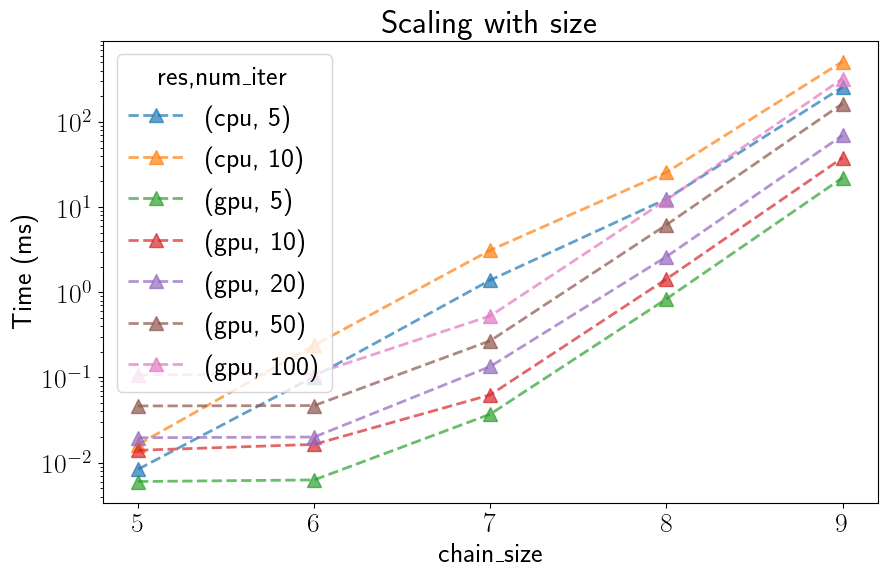

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
cpu_plot = mean_runtime_data.plot(
    title="Scaling with size",
    ylabel="Time (ms)",
    ax=ax,
    marker="^",
    lw=2,
    alpha=0.7,
    logy=True,
    markersize=10,
    ls="--",
    # label=,
)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
# ax.legend(handles=cpu_plot, labels=["CPU5", "CPU10"])
# ax.set(yscale=('log'))

[Text(0.5, 0, 'Chain size')]

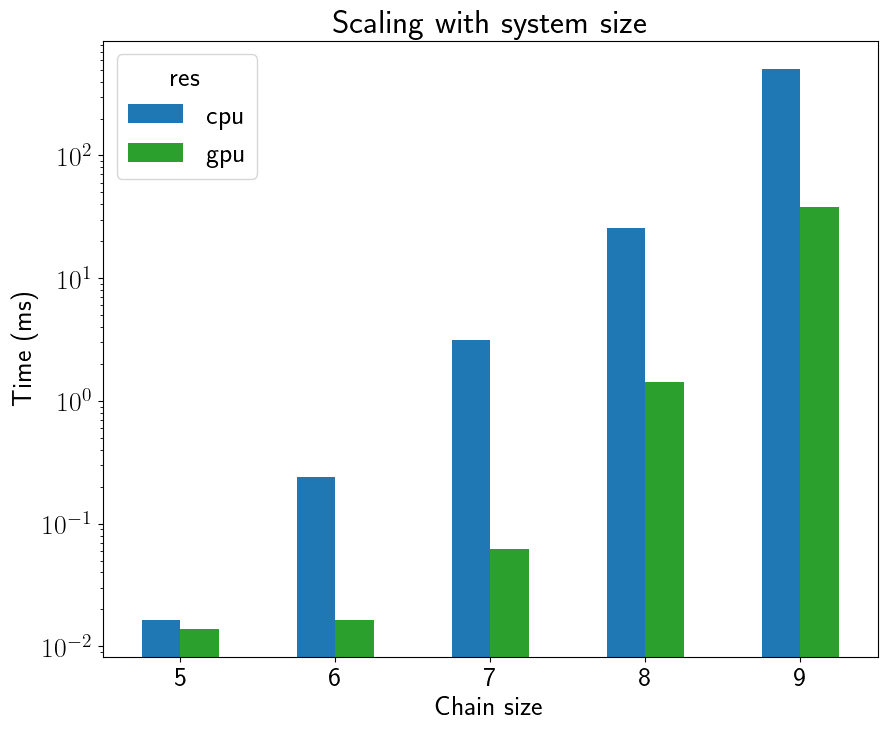

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
mean_runtime_data.xs(10, level="num_iter", axis=1).plot.bar(
    title="Scaling with system size",
    ylabel="Time (ms)",
    rot=0,
    ax=ax,
    color=["tab:blue", "tab:green"],
)
ax.set_yscale("log")
ax.set(xlabel="Chain size")

In [ ]:
speedup[[5, 10]]

num_iter,5,10
chain_size,,
5,1.392215,1.168544
6,16.336961,14.584313
7,37.411213,49.845728
8,14.881997,17.885303
9,11.569111,13.483458


/home/abhis/mambaforge/envs/nvip_env/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


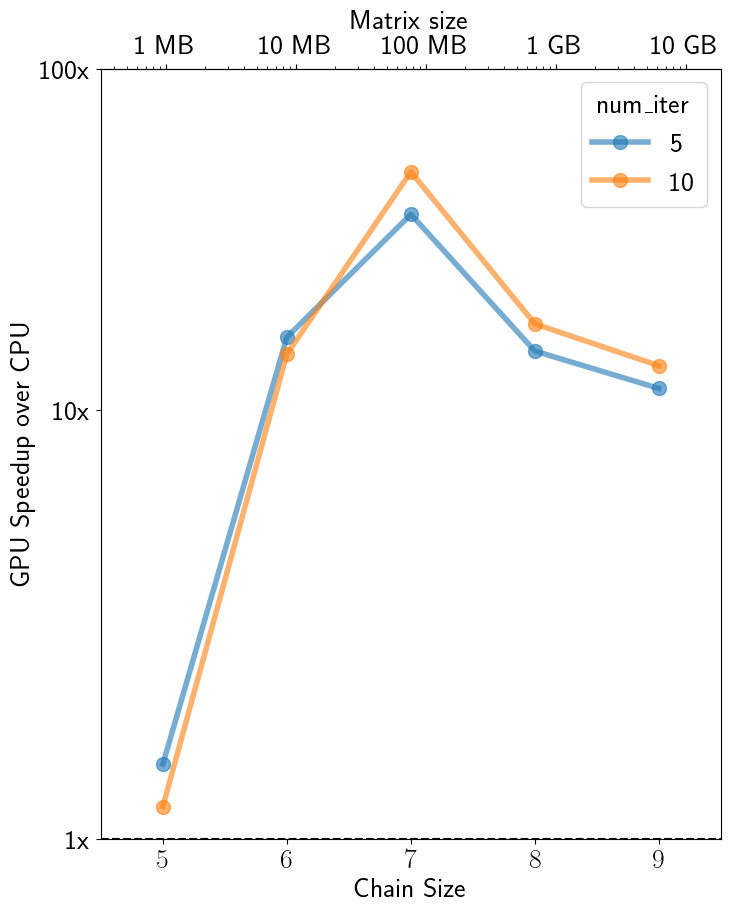

In [ ]:
speedup = (mean_runtime_data["cpu"] / mean_runtime_data["gpu"]).apply(
    np.vectorize(lambda x: -1 / x if x < 1 else x)
)
fig, ax = plt.subplots(1, 1, figsize=(8, 10))
speedup[[5, 10]].plot(
    ax=ax,
    ylabel="GPU Speedup over CPU",
    xlabel="Chain Size",
    # color="tab:green",
    marker="o",
    markersize=10,
    lw=4,
    alpha=0.6,
)


def chainsize2matsize(x):
    return 3 ** (2 * x) * 16 * 1e-06


def matsize2chainsize(x):
    return np.log(x / (16 * 1e-06)) / (2 * np.log(3))


# ax.legend(handles=['5' , '10'], frameon=False)
ax.axhline(1, color="k", linestyle="--")
ax.set(
    xlim=(4.5, 9.5),
    yscale="symlog",
    ylim=(1, 100),
    yticks=[1, 10, 100],
    yticklabels=["1x", "10x", "100x"],
)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
# ax.set(xscale="log")

matsizeax = ax.secondary_xaxis("top", functions=(chainsize2matsize, matsize2chainsize))
matsizeax.set(
    xlabel="Matrix size",
    xscale="log",
)
matsizeax.set_xlim((1, 1e5))
matsizeax.set_xticks([1, 10, 100, 1e3, 1e4])
matsizeax.set_xticklabels(["1 MB", "10 MB", "100 MB", "1 GB", "10 GB"])
# ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

<Axes: xlabel='chain_size'>

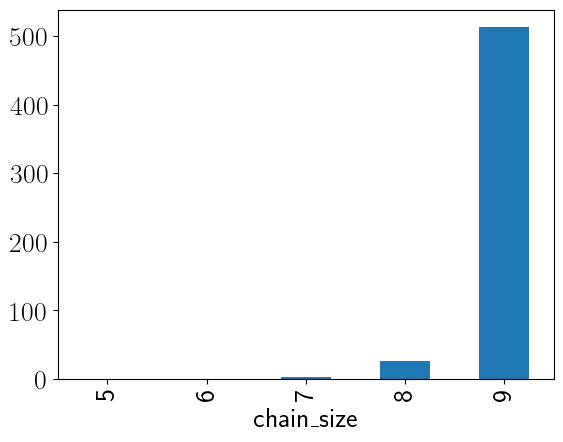

In [ ]:
cpu_scaling = mean_runtime_data.xs("cpu", level="res", axis=1)
cpu_scaling[10].plot.bar()

AttributeError: 'numpy.ndarray' object has no attribute 'get_figure'

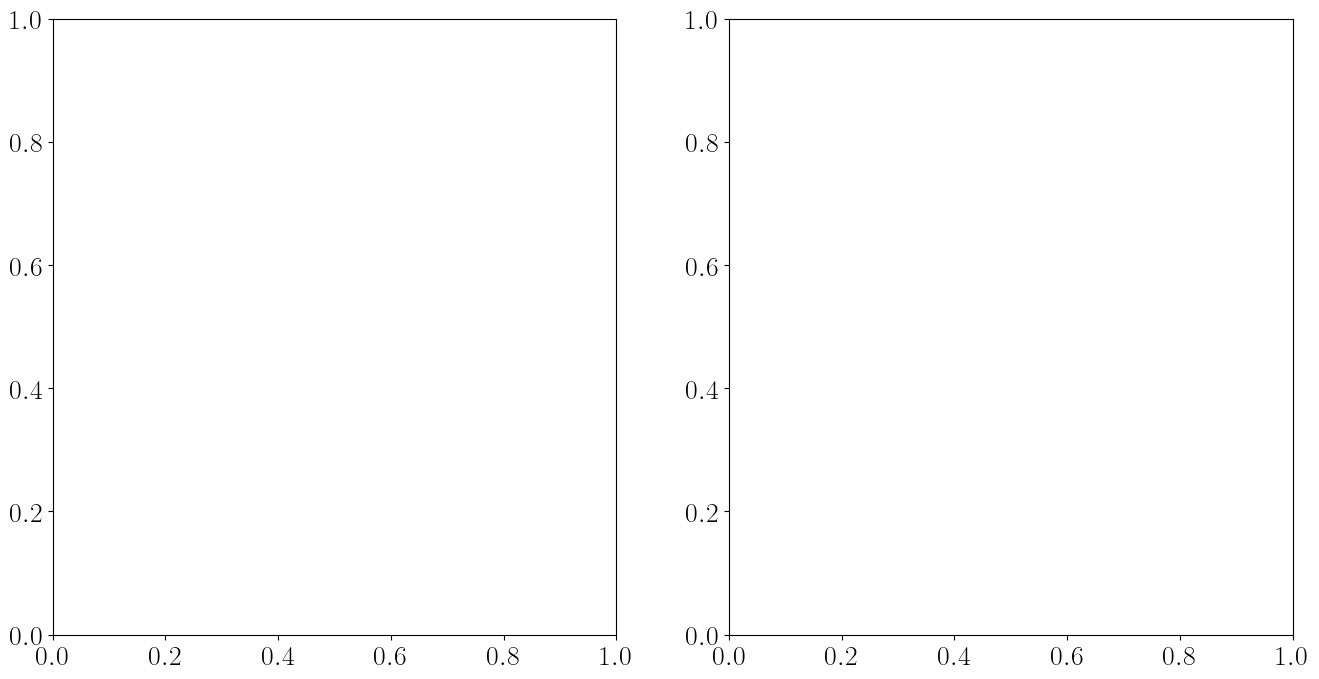

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
(cpu_scaling[5]).plot.bar(
    title="Scaling with system size",
    ylabel="Time (ms)",
    rot=0,
    ax=ax,
    # color=[ 'tab:blue', 'tab:green']
)
ax.set_yscale("log")
ax.set(xlabel="Chain size")

# Baseline Data

In [ ]:
baseline_data = pd.json_normalize(
    data=json.load(open(".data/baseline_data.json"))["benchmarks"]
)

baseline_data["dim"] = baseline_data["param"].astype(int)
baseline_data["mat_size"] = (baseline_data["param"].astype(int)) ** 2 * 16 * 1e-6
baseline_data[["test", "res"]] = baseline_data["name"].str.extract(
    r"test_([a-z0-9_]+)_(cpu|gpu)\[\d+\]"
)
baseline_data.head()

,group,name,fullname,param,params.data_cpu,options.disable_gc,options.timer,options.min_rounds,options.max_time,options.min_time,...,stats.hd15iqr,stats.ops,stats.total,stats.data,stats.iterations,params.data_gpu,dim,mat_size,test,res
0,None,test_transpose_cpu[10],examples/benchmark_baseline_cpu.py::test_trans...,10,10.0,False,perf_counter,5,1.0,0.000005,...,0.000002,480464.392339,0.000010,"[2.304092049598694e-06, 1.885928213596344e-06,...",1,NaN,10,0.0016,transpose,cpu
1,None,test_dagger_cpu[10],examples/benchmark_baseline_cpu.py::test_dagge...,10,10.0,False,perf_counter,5,1.0,0.000005,...,0.000003,359736.606808,0.000014,"[2.3758038878440857e-06, 2.4437904357910156e-0...",1,NaN,10,0.0016,dagger,cpu
2,None,test_matmul_cpu[10],examples/benchmark_baseline_cpu.py::test_matmu...,10,10.0,False,perf_counter,5,1.0,0.000005,...,0.000008,203391.010759,0.000025,"[4.190020263195038e-06, 8.031725883483887e-06,...",1,NaN,10,0.0016,matmul,cpu
3,None,test_matmul_inplace_cpu[10],examples/benchmark_baseline_cpu.py::test_matmu...,10,10.0,False,perf_counter,5,1.0,0.000005,...,0.000005,193487.912928,0.000026,"[5.377456545829773e-06, 5.16790896654129e-06, ...",1,NaN,10,0.0016,matmul_inplace,cpu
4,None,test_einsum_2_cpu[10],examples/benchmark_baseline_cpu.py::test_einsu...,10,10.0,False,perf_counter,5,1.0,0.000005,...,0.000009,124509.128690,0.000040,"[7.2624534368515015e-06, 8.520670235157013e-06...",1,NaN,10,0.0016,einsum_2,cpu


In [ ]:
mean_baseline_data = baseline_data[
    ["res", "dim", "mat_size", "test", "stats.mean"]
].pivot_table(columns=["res", "mat_size"], index="test", values="stats.mean")
mean_baseline_data

res                  cpu                  gpu          
mat_size          0.0016     0.1600    0.0016    0.1600
test                                                   
argmax          0.000004   0.000021  0.000059  0.000065
argmin          0.000003   0.000020  0.000057  0.000064
dagger          0.000003   0.000011  0.000024  0.000023
einsum_2        0.000008   0.002262  0.000223  0.000216
einsum_3        0.000050   0.301144  0.000368  0.000370
einsum_4        0.000782  55.682016  0.000506  0.000505
matmul          0.000005   0.000128  0.000089  0.000090
matmul_inplace  0.000005   0.000116  0.000109  0.000106
transpose       0.000002   0.000002  0.000007  0.000006

In [ ]:
baseline_speedup = (
    mean_baseline_data.xs("cpu", level="res", axis=1)
    / mean_baseline_data.xs("gpu", level="res", axis=1)
).apply(np.vectorize(lambda x: -1 / x if x < 1 else x))
baseline_scaling = baseline_speedup.T

baseline_scaling

test,argmax,argmin,dagger,einsum_2,einsum_3,einsum_4,matmul,matmul_inplace,transpose
mat_size,,,,,,,,,
0.0016,-16.256834,-18.27817,-8.602653,-27.729841,-7.427214,1.546714,-18.19412,-21.029949,-3.201360
0.1600,-3.157070,-3.17428,-2.103159,10.483241,813.970760,110349.621413,1.42988,1.091791,-3.139687


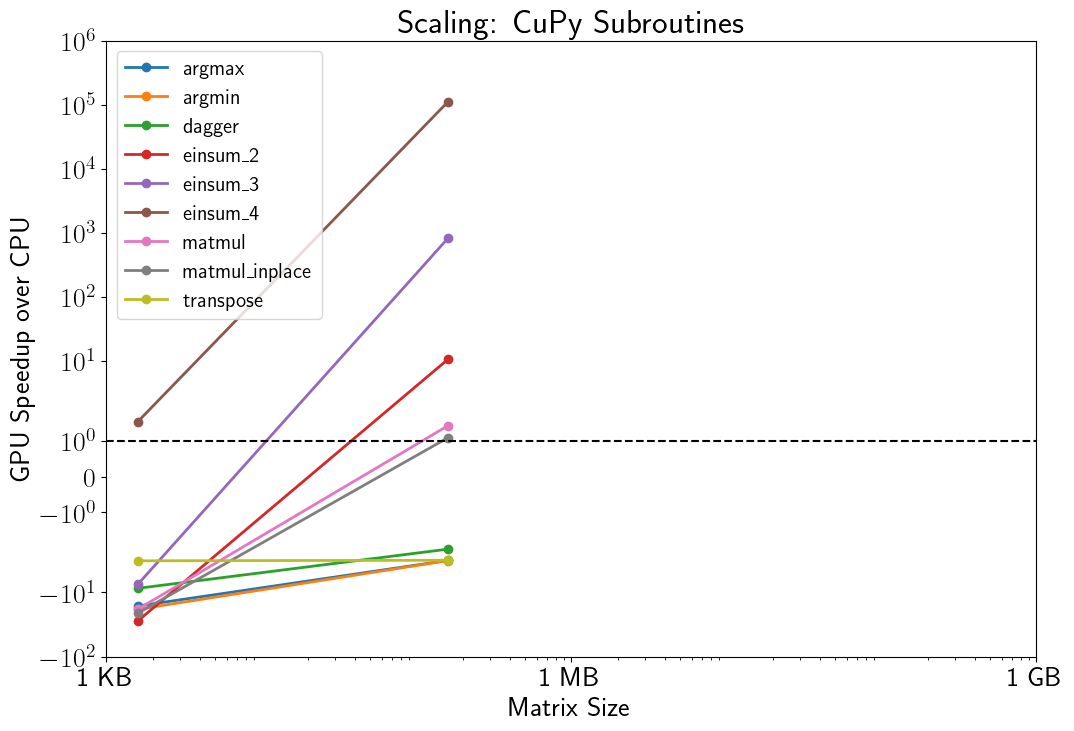

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
baseline_scaling.plot(
    ax=ax,
    title="Scaling: CuPy Subroutines",
    ylabel="GPU Speedup over CPU",
    xlabel="Matrix Size",
    marker="o",
    lw=2,
    # rot=0,
    # figsize=(16, 8),
)
ax.axhline(1, color="k", linestyle="--")
ax.set(
    yscale="symlog",
    ylim=(-1e2, 1e6),
    xscale="log",
    xticks=[1e-3, 1, 1e3],
    xticklabels=["1 KB", "1 MB", "1 GB"],
)
ax.legend(fontsize=15, loc="upper left")
# ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

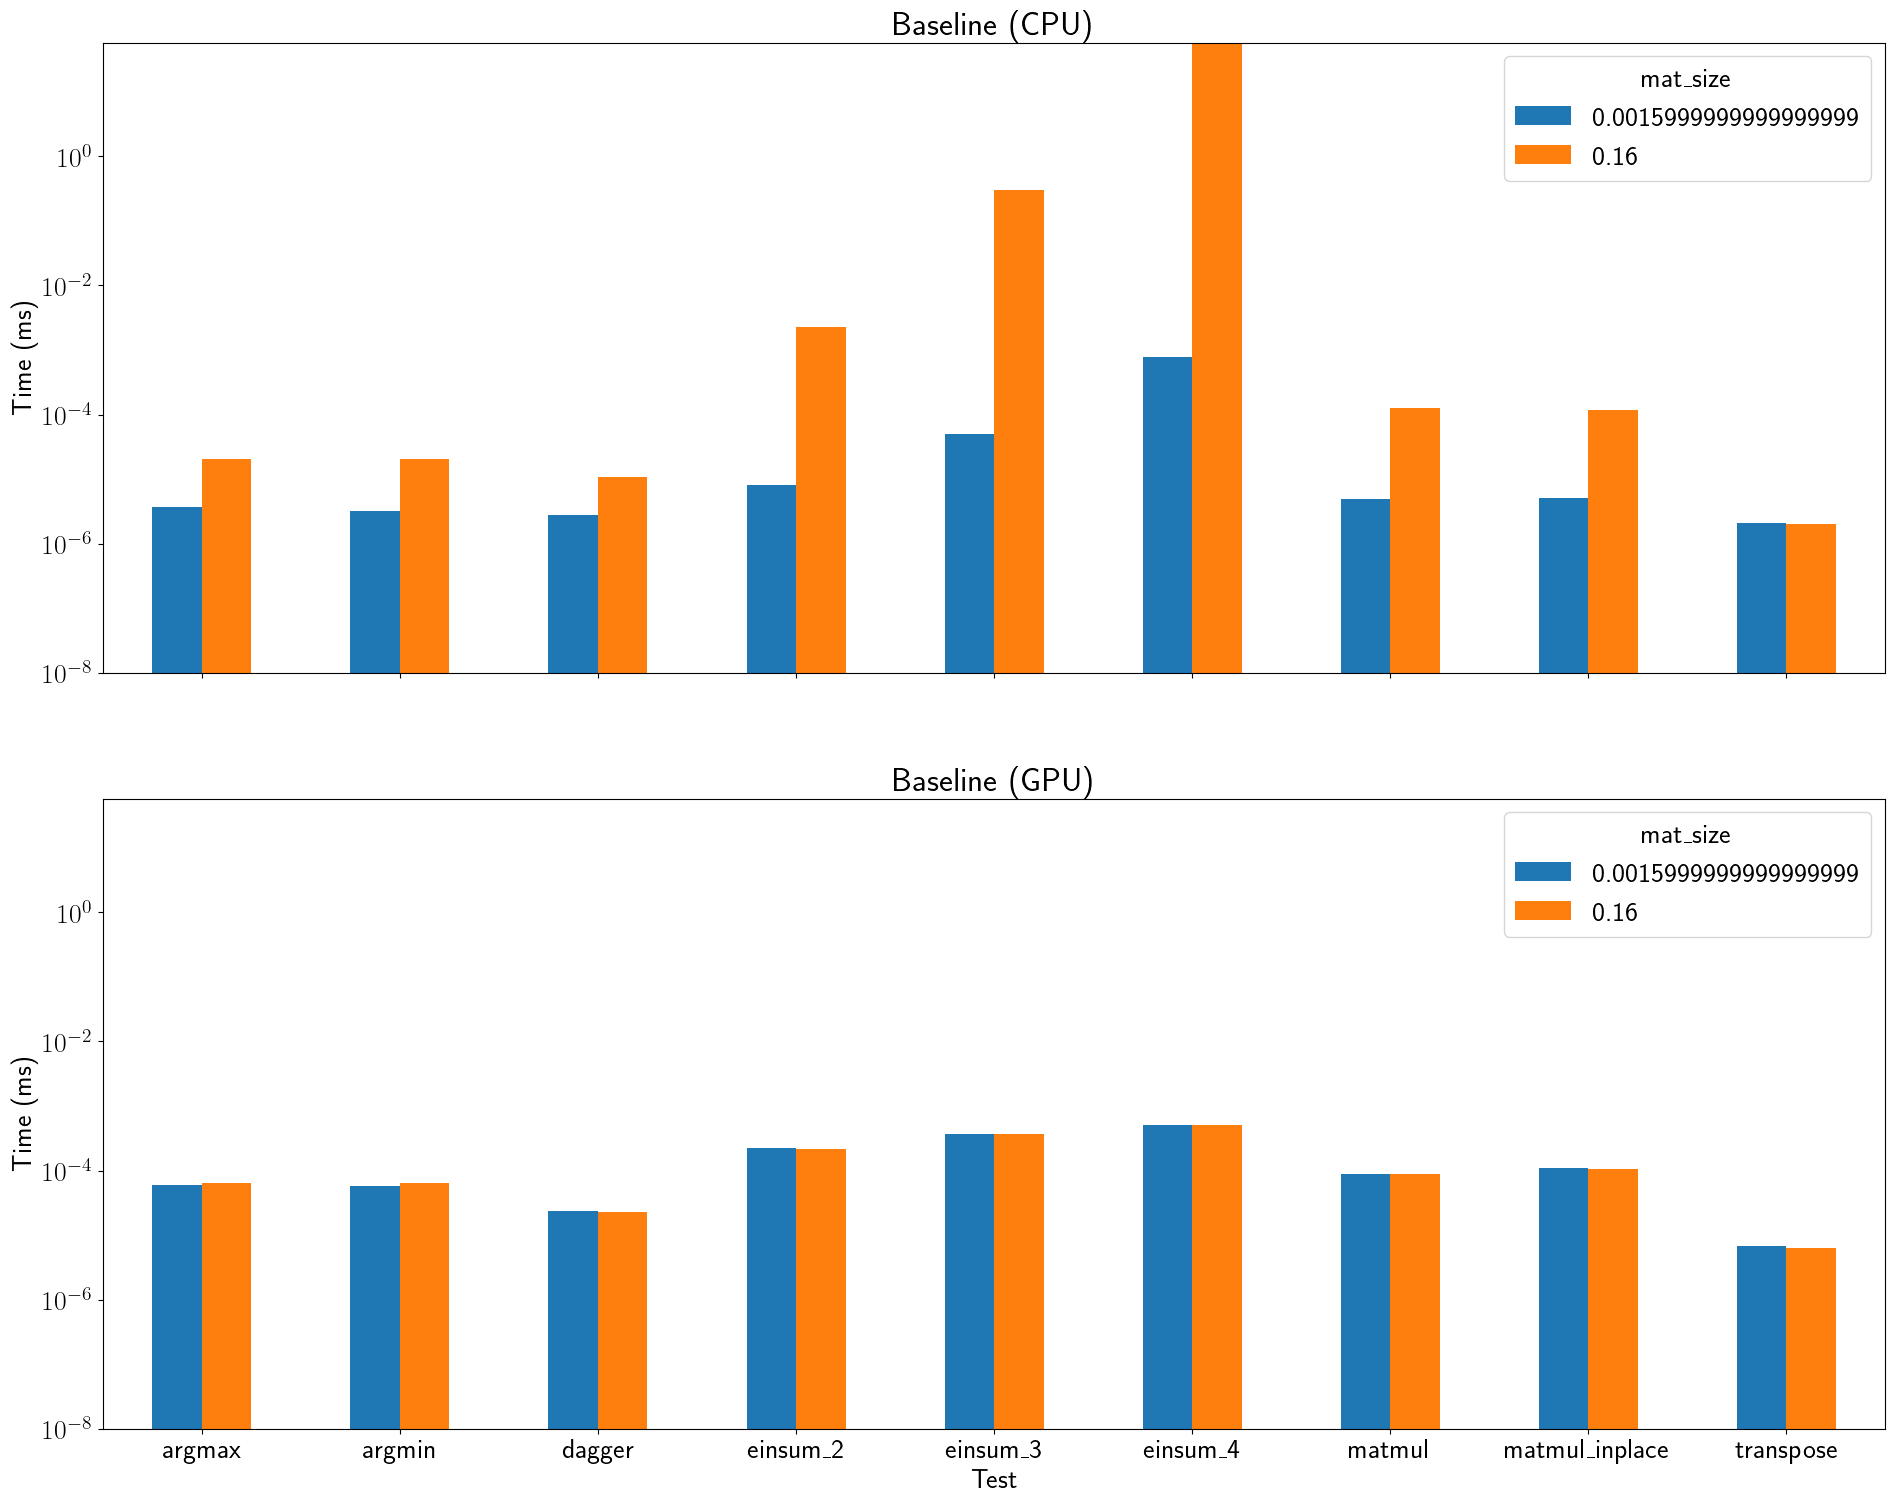

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(23, 18), sharex=True, sharey=True)

mean_baseline_data.xs("cpu", level="res", axis=1).plot.bar(
    title="Baseline (CPU)", ylabel="Time (ms)", rot=0, ax=ax[0]
)
mean_baseline_data.xs("gpu", level="res", axis=1).plot.bar(
    title="Baseline (GPU)", ylabel="Time (ms)", rot=0, ax=ax[1]
)
for axis in ax:
    axis.set(ylim=(1e-8), xlabel="Test")
    axis.set_yscale("log")

# Utils baseline

In [ ]:
utils_data = pd.json_normalize(
    data=json.load(open(".data/utils_data.json"))["benchmarks"]
)

utils_data["dim"] = utils_data["param"].astype(int)
utils_data["mat_size"] = (utils_data["param"].astype(int)) ** 2 * 16 * 1e-6

utils_data[["test", "res"]] = utils_data["name"].str.extract(
    r"test_([a-z0-9_]+)_(cpu|gpu)\[\d+\]"
)
utils_data.head()

,group,name,fullname,param,params.data_cpu,options.disable_gc,options.timer,options.min_rounds,options.max_time,options.min_time,...,stats.total,stats.data,stats.iterations,params.test_dim,params.data_gpu,params.dim,dim,mat_size,test,res
0,None,test_extract_num_params_cpu[10],examples/benchmark_utils_cpu.py::test_extract_...,10,10.0,False,perf_counter,5,1.0,0.000005,...,0.000025,"[5.052114526430766e-06, 5.028521021207173e-06,...",3,NaN,NaN,NaN,10,0.0016,extract_num_params,cpu
1,None,test_unitary_transformation_cpu[10],examples/benchmark_utils_cpu.py::test_unitary_...,10,10.0,False,perf_counter,5,1.0,0.000005,...,0.000030,"[6.099852422873179e-06, 5.889994402726491e-06,...",3,NaN,NaN,NaN,10,0.0016,unitary_transformation,cpu
2,None,test_find_largest_coupling_cpu[10],examples/benchmark_utils_cpu.py::test_find_lar...,10,10.0,False,perf_counter,5,1.0,0.000005,...,0.000069,"[1.3805304964383444e-05, 1.3712172706921896e-0...",3,NaN,NaN,NaN,10,0.0016,find_largest_coupling,cpu
3,None,test_split_diag_offdiag_matrix_cpu[10],examples/benchmark_utils_cpu.py::test_split_di...,10,10.0,False,perf_counter,5,1.0,0.000005,...,0.000022,"[4.423471788565318e-06, 4.307056466738383e-06,...",3,NaN,NaN,NaN,10,0.0016,split_diag_offdiag_matrix,cpu
4,None,test_extract_num_params_cpu[100],examples/benchmark_utils_cpu.py::test_extract_...,100,100.0,False,perf_counter,5,1.0,0.000005,...,0.000025,"[4.865539570649465e-06, 4.9586718281110125e-06...",3,NaN,NaN,NaN,100,0.1600,extract_num_params,cpu


In [ ]:
mean_utils_data = utils_data[
    ["res", "dim", "mat_size", "test", "stats.mean"]
].pivot_table(columns=["mat_size", "res"], index="test", values="stats.mean")
mean_utils_data

mat_size                  0.0016              0.1600              16.0000    \
res                             cpu       gpu       cpu       gpu       cpu   
test                                                                          
extract_num_params         0.000005  0.000088  0.000005  0.000086  0.000005   
find_largest_coupling      0.000014  0.000401  0.000063  0.000410  0.004813   
givens_rot_creation        0.000009  0.000181  0.000012  0.000181  0.000655   
split_diag_offdiag_matrix  0.000004  0.000063  0.000019  0.000065  0.003436   
unitary_transformation     0.000006  0.000055  0.000299  0.000061  0.055893   

mat_size                            1600.0000            
res                             gpu       cpu       gpu  
test                                                     
extract_num_params         0.000086  0.000005  0.000086  
find_largest_coupling      0.000407  0.518138  0.005429  
givens_rot_creation        0.000181  0.009882  0.000935  
split_diag_offdiag_matrix  0.000087  0.369145  0.003584  
unitary_transformation     0.000981  7.097632  0.828879

In [ ]:
utils_speedup = (
    mean_utils_data.xs("cpu", level="res", axis=1)
    / mean_utils_data.xs("gpu", level="res", axis=1)
).apply(np.vectorize(lambda x: -1 / x if x < 1 else x))
utils_scaling = utils_speedup.T

utils_scaling

test,extract_num_params,find_largest_coupling,givens_rot_creation,split_diag_offdiag_matrix,unitary_transformation
mat_size,,,,,
0.0016,-17.613302,-29.050747,-19.246902,-14.655160,-9.167213
0.1600,-17.596428,-6.511639,-14.992402,-3.459177,4.868872
16.0000,-17.565151,11.815199,3.621605,39.613855,56.970069
1600.0000,-17.317614,95.433289,10.572756,103.006383,8.562924


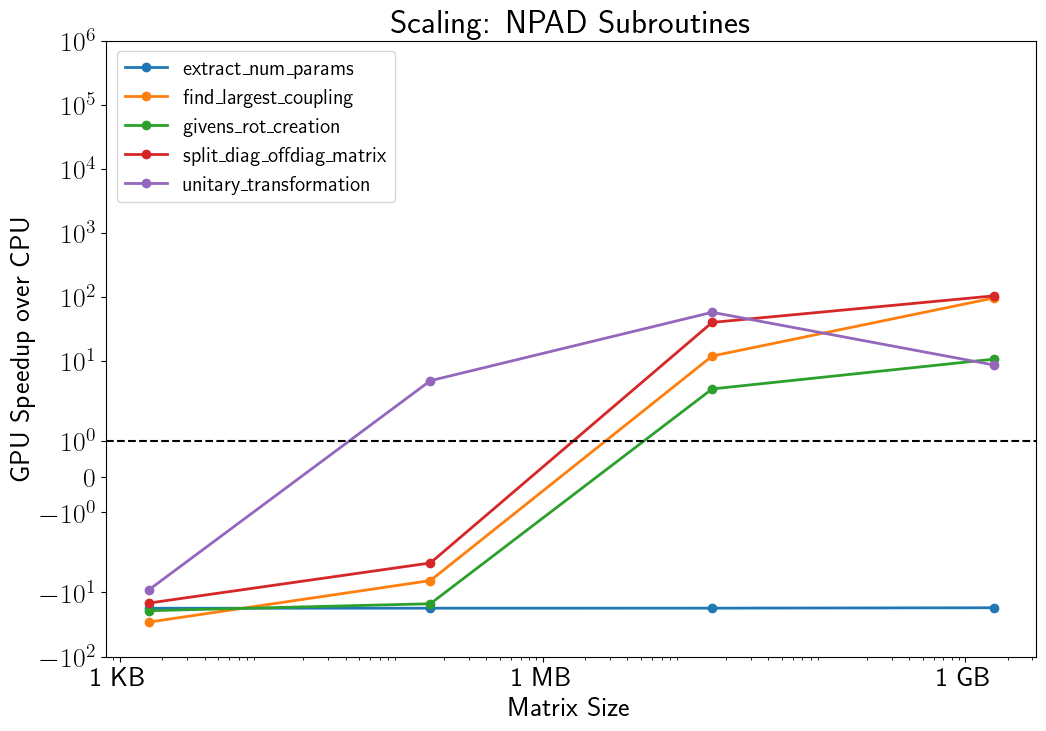

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
utils_scaling.plot(
    ax=ax,
    title="Scaling: NPAD Subroutines",
    ylabel="GPU Speedup over CPU",
    xlabel="Matrix Size",
    marker="o",
    lw=2,
    # rot=0,
    # figsize=(16, 8),
)
ax.axhline(1, color="k", linestyle="--")
ax.set(
    yscale="symlog",
    ylim=(-1e2, 1e6),
    xscale="log",
    xticks=[1e-3, 1, 1e3],
    xticklabels=["1 KB", "1 MB", "1 GB"],
)
ax.legend(fontsize=15, loc="upper left")
# ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

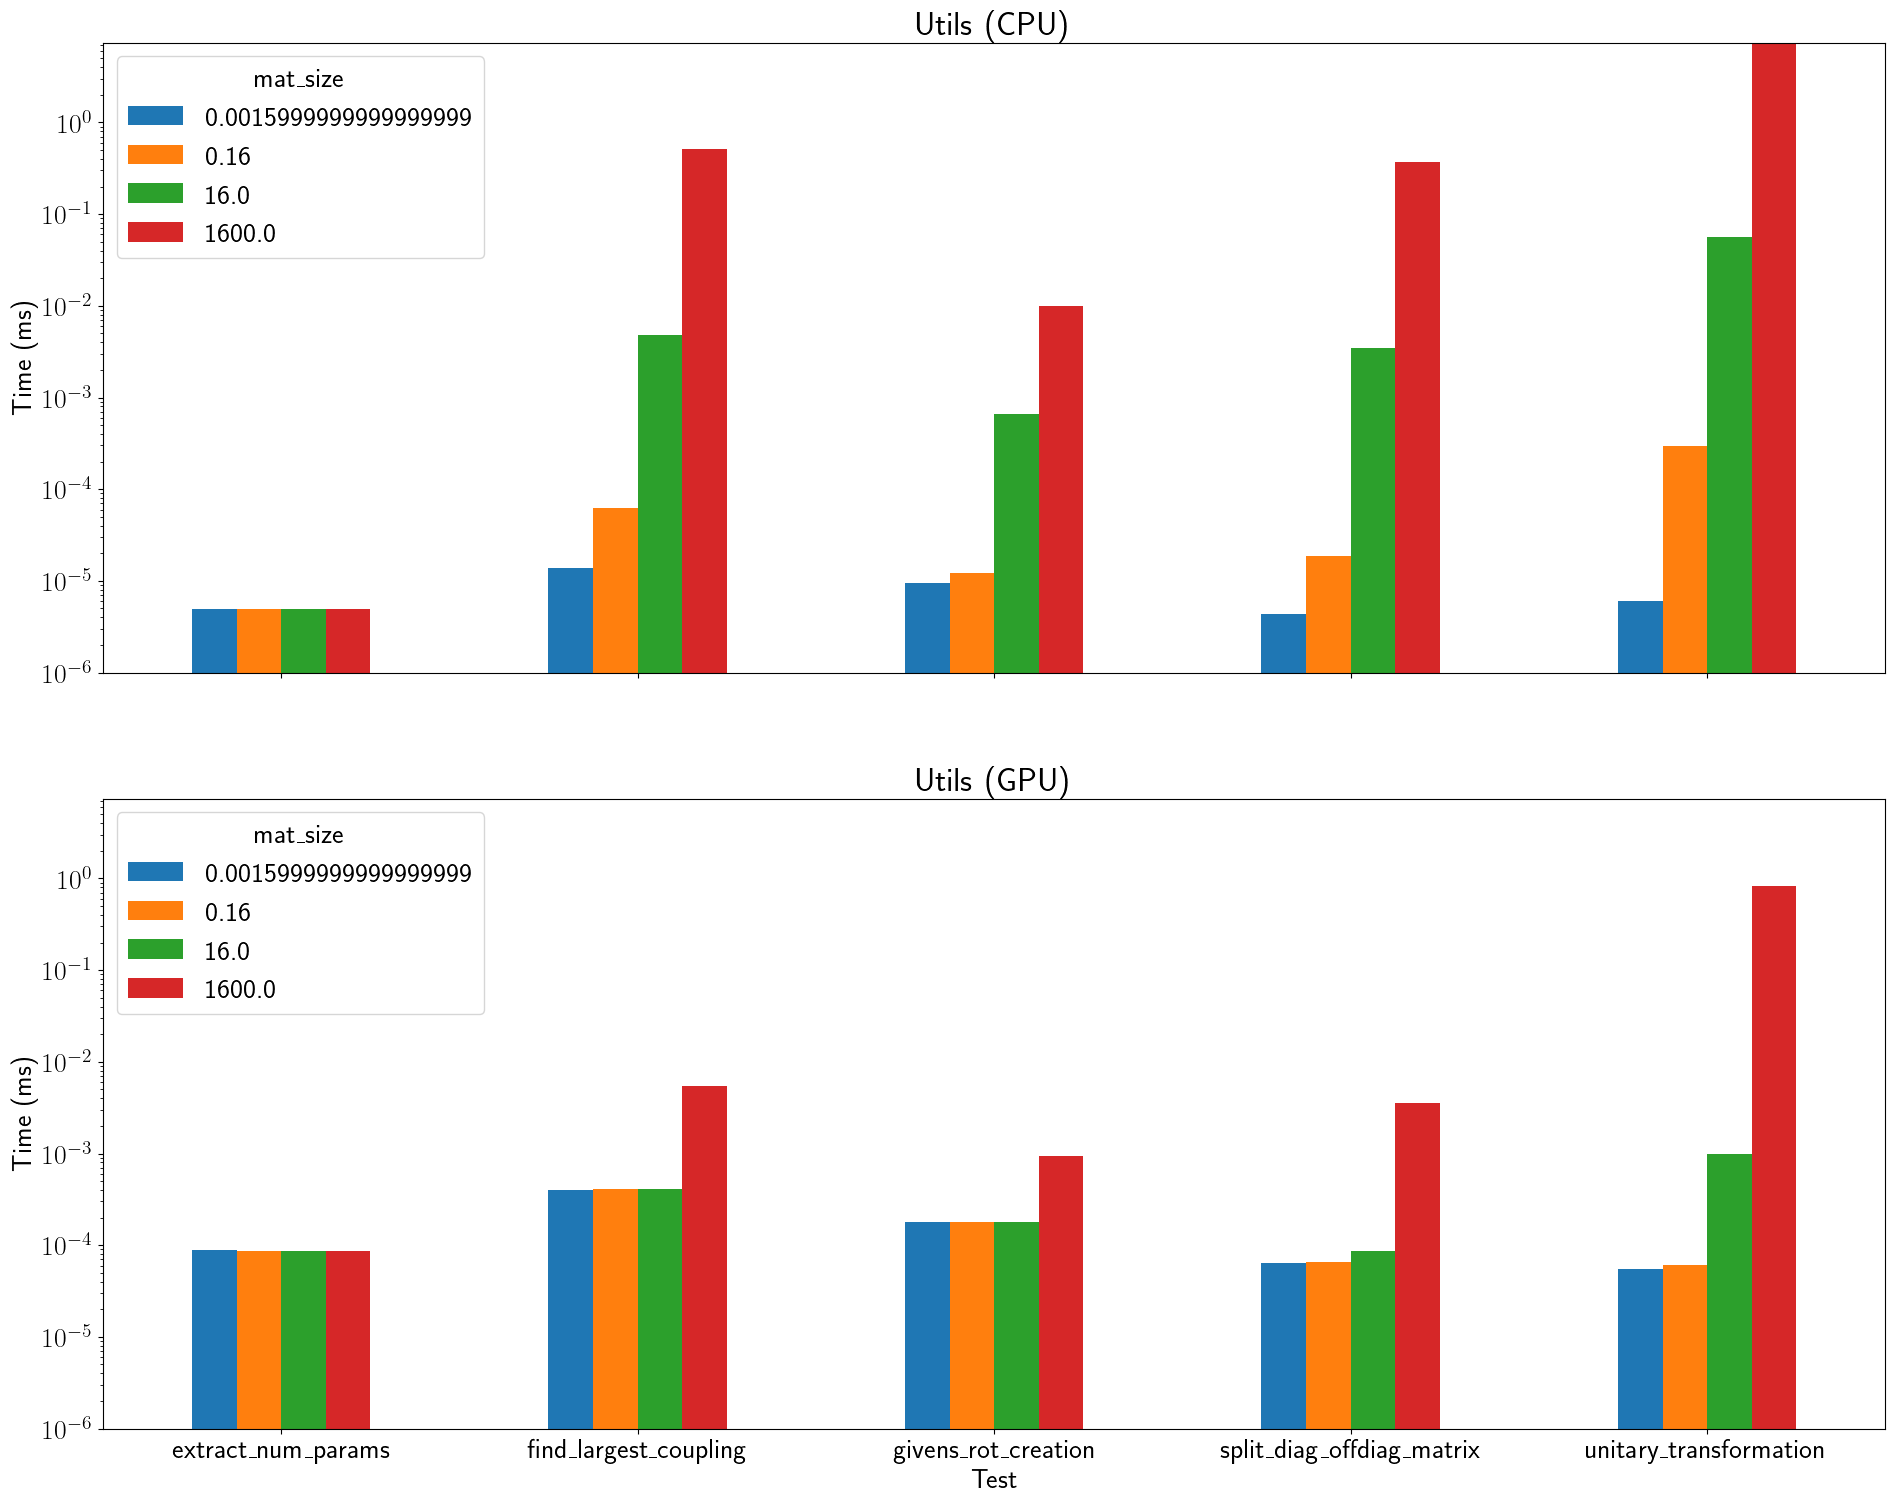

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(23, 18), sharex=True, sharey=True)

mean_utils_data.xs("cpu", level="res", axis=1).plot.bar(
    title="Utils (CPU)", ylabel="Time (ms)", rot=0, ax=ax[0]
)
mean_utils_data.xs("gpu", level="res", axis=1).plot.bar(
    title="Utils (GPU)", ylabel="Time (ms)", rot=0, ax=ax[1]
)
for axis in ax:
    axis.set(ylim=(1e-6), xlabel="Test")
    axis.set_yscale("log")

# Combined scaling plot

Text(0.5, 0.98, 'Scaling')

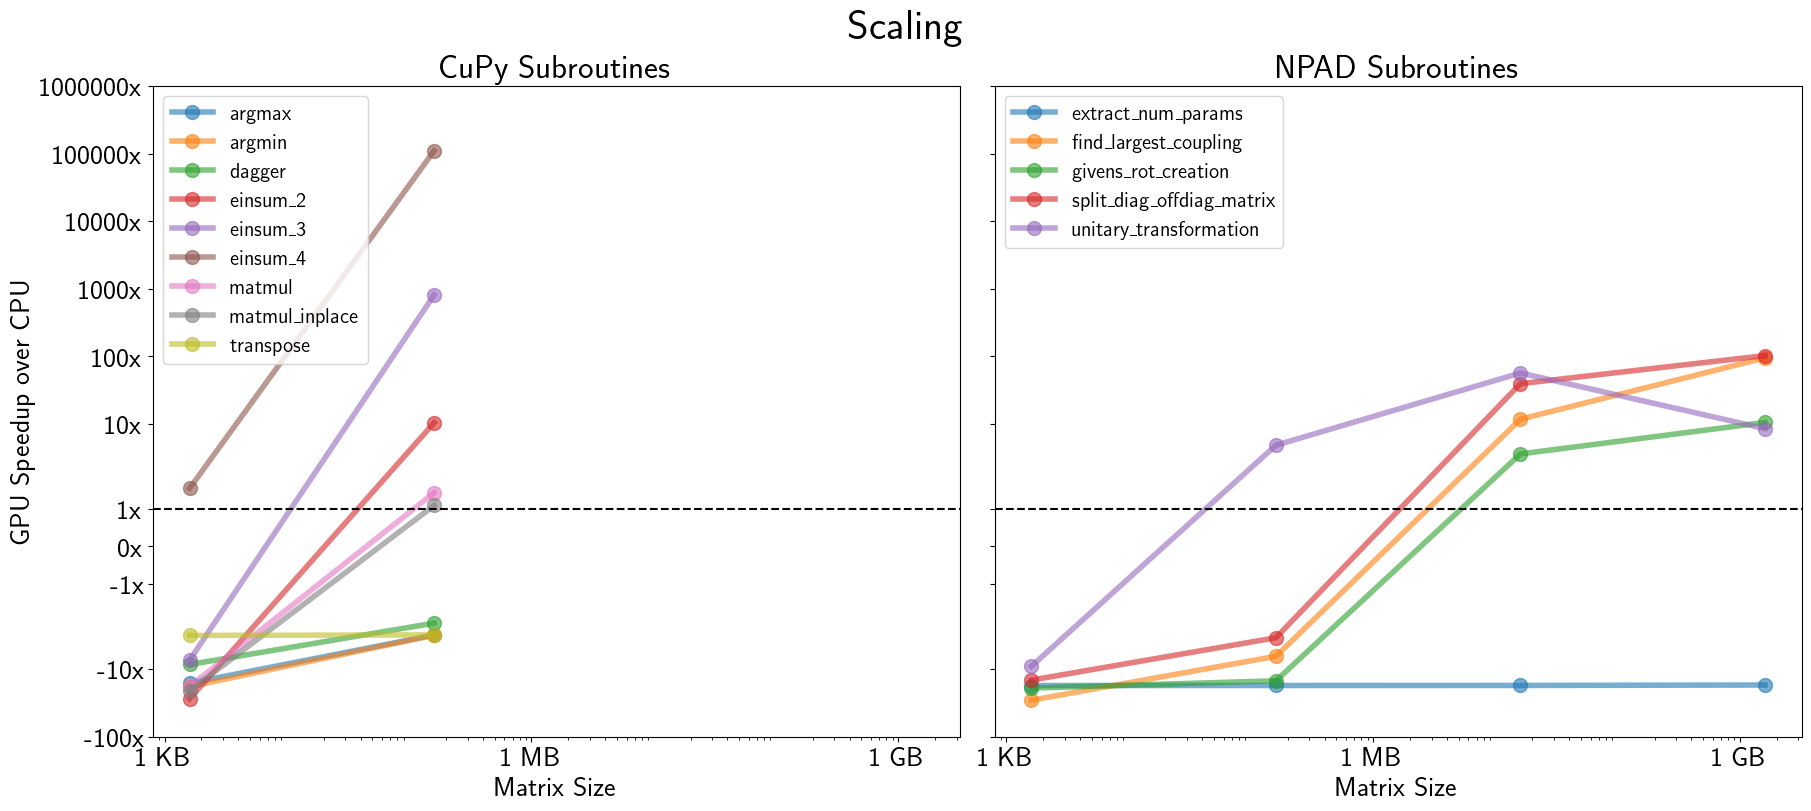

In [ ]:
fig, ax = plt.subplots(
    1, 2, figsize=(18, 8), sharey=True, sharex=True, layout="constrained"
)
baseline_scaling.plot(
    ax=ax[0],
    title="CuPy Subroutines",
    ylabel="GPU Speedup over CPU",
    xlabel="Matrix Size",
    marker="o",
    markersize=10,
    lw=4,
    alpha=0.6,
    # rot=0,
    # figsize=(16, 8),
)

utils_scaling.plot(
    ax=ax[1],
    title="NPAD Subroutines",
    ylabel="GPU Speedup over CPU",
    xlabel="Matrix Size",
    marker="o",
    markersize=10,
    lw=4,
    alpha=0.6,
    # rot=0,
    # figsize=(16, 8),
)

ax[0].set(
    yscale="symlog",
    ylim=(-1e2, 1e6),
    xscale="log",
    xticks=[1e-3, 1, 1e3],
    xticklabels=["1 KB", "1 MB", "1 GB"],
)

ax[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:.0f}x"))

ax[0].axhline(1, color="k", linestyle="--")
ax[1].axhline(1, color="k", linestyle="--")

ax[0].legend(fontsize=15, loc="upper left")
ax[1].legend(fontsize=15, loc="upper left")
fig.suptitle("Scaling", fontsize=30)

# Magnus things

## expm()

In [13]:
from mpl_toolkits.mplot3d import Axes3D

expm_data = pd.json_normalize(
    data=json.load(open(".data/expm_data.json"))["benchmarks"]
)
expm_data[["test", "res", "dim", "batch_size"]] = expm_data["name"].str.extract(
    r"test_([a-z0-9_]+)_(cpu|gpu)\[k=(\d+), N=(\d+)\]"
)
expm_data["mat_size"] = (
    expm_data["batch_size"].astype(int)
    * (expm_data["dim"].astype(int)) ** 2
    * 16
    * 1e-6
)

expm_data.get(
    [
        "test",
        "res",
        "dim",
        "batch_size",
        "mat_size",
        "stats.mean",
    ]
)

,test,res,dim,batch_size,mat_size,stats.mean
0,expm,cpu,1,10,0.00016,0.000328
1,expm,cpu,1,100,0.00160,0.044490
2,expm,cpu,1,1000,0.01600,0.711624
3,expm,cpu,2,10,0.00064,0.000442
4,expm,cpu,2,100,0.00640,0.015739
5,expm,cpu,2,1000,0.06400,1.401516
6,expm,cpu,5,10,0.00400,0.000462
7,expm,cpu,5,100,0.04000,0.036926
8,expm,cpu,5,1000,0.40000,3.798406
9,expm,cpu,10,10,0.01600,0.001036


In [ ]:
expm_bench_data = (
    expm_data.get(
        [
            "test",
            "res",
            "dim",
            "batch_size",
            "mat_size",
            "stats.mean",
        ]
    )
    .astype(
        {
            "test": str,
            "res": str,
            "dim": int,
            "batch_size": int,
            "mat_size": float,
            "stats.mean": float,
        }
    )
    .pivot_table(columns=["res"], index="mat_size", values="stats.mean")
    # .pivot_table(columns=["res"], index=['dim', 'batch_size'], values=["stats.mean", "mat_size"])
)
expm_bench_data

res,cpu,gpu
mat_size,,
0.00016,0.000328,0.002104
0.00064,0.000442,0.002879
0.00160,0.044490,0.002000
0.00400,0.000462,0.003910
0.00640,0.015739,0.002050
0.01600,0.356330,0.004762
0.04000,0.036926,0.002060
0.06400,1.401516,0.010445
0.16000,0.072792,0.002853


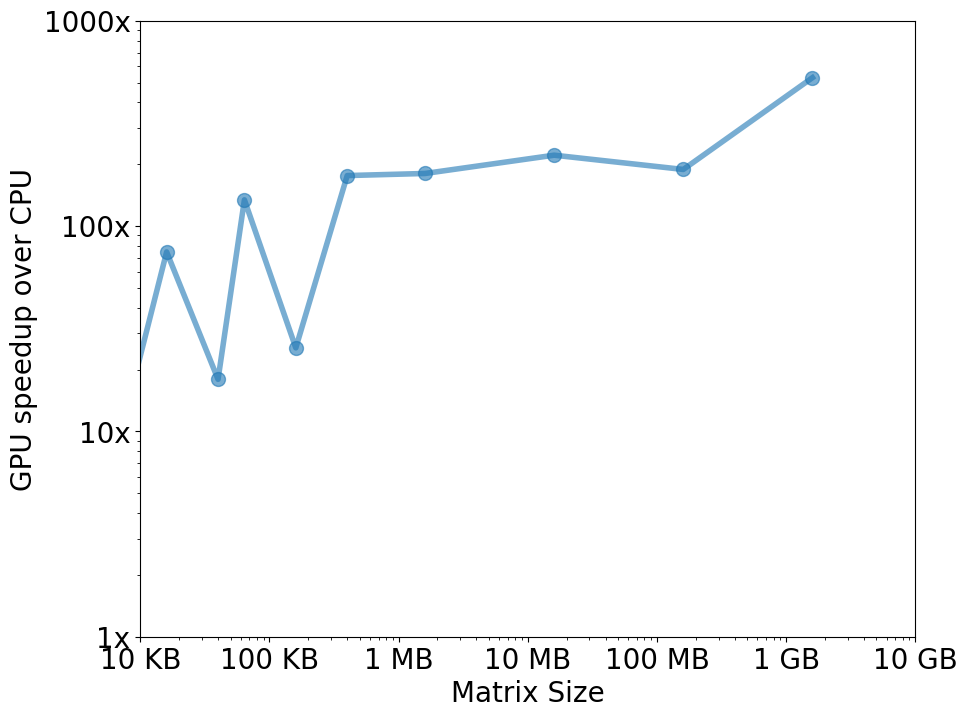

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

speedup = expm_bench_data["cpu"] / expm_bench_data["gpu"]

speedup.plot(
    ax=ax,
    logy=True,
    logx=True,
    marker="o",
    markersize=10,
    lw=4,
    alpha=0.6,
)
ax.set(
    xlabel="Matrix Size",
    ylabel="GPU speedup over CPU",
    xlim=(1, 1e4),
    xticks=[0.01, 0.1, 1, 10, 100, 1e3, 1e4],
    xticklabels=["10 KB", "100 KB", "1 MB", "10 MB", "100 MB", "1 GB", "10 GB"],
    yticks=[1, 10, 100, 1e3],
    yticklabels=["1x", "10x", "100x", "1000x"],
    ylim=(1, 1e3),
)